In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_spd_matrix

from scipy import random
from scipy.stats import multivariate_normal

from GMM import GMM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
mean_range = (0, 10)
prop_first_component = 0.8

def generate_data(prop_first_component, n_components=2, n_samples=1000):
    n_samples_first = int(n_samples * prop_first_component)
    n_samples_second = n_samples - n_samples_first
    # Randomly generate means
    means = np.random.uniform(mean_range[0], mean_range[1], (n_components, 2))

    # Randomly generate full covariance matrices
    covariances = [make_spd_matrix(2) for _ in range(n_components)]

    # Generate example data for each component
    data_adjusted = np.vstack([
        np.random.multivariate_normal(means[0], covariances[0], n_samples_first),
        np.random.multivariate_normal(means[1], covariances[1], n_samples_second)
    ])
    labels = np.hstack([np.zeros(n_samples_first), np.ones(n_samples_second)])


    return data_adjusted, labels, n_samples_first, means, covariances

def estimation_errors(estimated_means, estimated_covariances, estimated_mixture_weights, true_means, true_covariances, true_mixture_weights):
    sort_indices = np.argsort(estimated_mixture_weights)[::-1]
    # print(estimated_mixture_weights, sort_indices)

    ordered_est_means = estimated_means[sort_indices]
    ordered_est_covariances = estimated_covariances[sort_indices]
    ordered_est_weights = estimated_mixture_weights[sort_indices]

    # Calculate and average the mean absolute differences
    mean_diffs = [np.mean(np.abs(ordered_est_means[i] - true_means[i]))
                for i in range(len(true_means))]
    cov_diffs = [np.mean(np.abs(ordered_est_covariances[i] - covariances[i]))
                for i in range(len(covariances))]
    weight_diffs = np.abs(ordered_est_weights - [0.8, 0.2])

    mean_abs_diff_means = np.mean(mean_diffs)
    mean_abs_diff_covs = np.mean(cov_diffs)
    mean_abs_diff_weights = np.mean(weight_diffs)

    # print("Mean Absolute Difference in Means:", mean_abs_diff_means)
    # print("Mean Absolute Difference in Covariances:", mean_abs_diff_covs)
    # print("Mean Absolute Difference in Mixture Weights:", mean_abs_diff_weights)
    return mean_abs_diff_means, mean_abs_diff_covs, mean_abs_diff_weights

data_adjusted, labels, n_samples_first, means, covariances = generate_data(prop_first_component)
# data_adjusted, labels

In [7]:
n_labeled_points = 1000


means_diffs_labeled = []
covs_diffs_labeled = []
weights_diffs_labeled = []
means_diffs_unlabeled = []
covs_diffs_unlabeled = []
weights_diffs_unlabeled = []




for i in range(20):
    
    print("on simulation ", i)
    
    data_adjusted, labels, n_samples_first, means, covariances = generate_data(prop_first_component)
    X = data_adjusted

    gmm_local = GMM(k=2, dim=2, labeled_data_weight=1.5)

    observed_idxs = np.random.choice(len(X), size=n_labeled_points, replace=False)
    observed_labels = labels[observed_idxs].astype(int)

    # print(X, X.shape)
    # print(observed_idxs, observed_idxs.shape)
    # print(observed_labels, observed_labels.shape)
    gmm_local.init_em(X, observed_idxs=observed_idxs, observed_labels=observed_labels)
    # gmm_local.init_em(X)
    gmm_local.init_params_with_kmeans(X)
    # print("local initialization \n")
    init_pi = gmm_local.pi
    init_mu = gmm_local.mu
    init_sigma = gmm_local.sigma

    gmm_local.fit(num_iters=30, tol=1e-4)

    estimated_params_w_labeled = gmm_local.get_params()

    local_means = np.array(estimated_params_w_labeled['mean'])
    local_covariances = np.array(estimated_params_w_labeled['cov'])
    local_mixture_weights = np.array(estimated_params_w_labeled['pi'])

    mean_abs_diff_means, mean_abs_diff_covs, mean_abs_diff_weights = estimation_errors(local_means, local_covariances, local_mixture_weights, means, covariances, [0.8, 0.2])
    print("Mean Absolute Difference in Means, Labeled: {:.3g}".format(mean_abs_diff_means))
    print("Mean Absolute Difference in Covariances, Labeled: {:.3g}".format(mean_abs_diff_covs))
    print("Mean Absolute Difference in Mixture Weights, Labeled: {:.3g}".format(mean_abs_diff_weights))
    means_diffs_labeled.append(mean_abs_diff_means)
    covs_diffs_labeled.append(mean_abs_diff_covs)
    weights_diffs_labeled.append(mean_abs_diff_weights)

    gmm_unlabeled = GMM(k=2, dim=2)
    gmm_unlabeled.init_em(X)
    gmm_unlabeled.init_params_with_kmeans(X)
    gmm_unlabeled.fit(num_iters=30, tol=1e-4)

    estimated_params_unlabeled = gmm_unlabeled.get_params()

    unlabeled_means = np.array(estimated_params_unlabeled['mean'])
    unlabeled_covariances = np.array(estimated_params_unlabeled['cov'])
    unlabeled_mixture_weights = np.array(estimated_params_unlabeled['pi'])

    mean_abs_diff_means, mean_abs_diff_covs, mean_abs_diff_weights = estimation_errors(unlabeled_means, unlabeled_covariances, unlabeled_mixture_weights, means, covariances, [0.8, 0.2])
    means_diffs_unlabeled.append(mean_abs_diff_means)
    covs_diffs_unlabeled.append(mean_abs_diff_covs)
    weights_diffs_unlabeled.append(mean_abs_diff_weights)

    print("Mean Absolute Difference in Means, Unlabeled: {:.3g}".format(mean_abs_diff_means))
    print("Mean Absolute Difference in Covariances, Unlabeled: {:.3g}".format(mean_abs_diff_covs))
    print("Mean Absolute Difference in Mixture Weights, Unlabeled: {:.3g}".format(mean_abs_diff_weights))
    # gmm0 = GaussianMixture(n_components=2, random_state=0, covariance_type='full')
    # gmm0.fit(X)
    
    # mean_abs_diff_means, mean_abs_diff_covs, mean_abs_diff_weights = estimation_errors(gmm0.means_, 
    #                                                                                gmm0.covariances_, 
    #                                                                                gmm0.weights_, 
    #                                                                                means, covariances, 
    #                                                                                [0.8, 0.2])
    # means_diffs_unlabeled.append(mean_abs_diff_means)
    # covs_diffs_unlabeled.append(mean_abs_diff_covs)
    # weights_diffs_unlabeled.append(mean_abs_diff_weights)
    print("\n")
    


on simulation  0
Mean Absolute Difference in Means, Labeled: 0.053
Mean Absolute Difference in Covariances, Labeled: 0.0781
Mean Absolute Difference in Mixture Weights, Labeled: 0
Mean Absolute Difference in Means, Unlabeled: 0.053
Mean Absolute Difference in Covariances, Unlabeled: 0.0785
Mean Absolute Difference in Mixture Weights, Unlabeled: 2.31e-09


on simulation  1
Mean Absolute Difference in Means, Labeled: 0.032
Mean Absolute Difference in Covariances, Labeled: 0.0868
Mean Absolute Difference in Mixture Weights, Labeled: 0
Mean Absolute Difference in Means, Unlabeled: 0.325
Mean Absolute Difference in Covariances, Unlabeled: 0.26
Mean Absolute Difference in Mixture Weights, Unlabeled: 0.0911


on simulation  2
Mean Absolute Difference in Means, Labeled: 0.0547
Mean Absolute Difference in Covariances, Labeled: 0.0398
Mean Absolute Difference in Mixture Weights, Labeled: 0
Mean Absolute Difference in Means, Unlabeled: 0.0478
Mean Absolute Difference in Covariances, Unlabeled: 0.

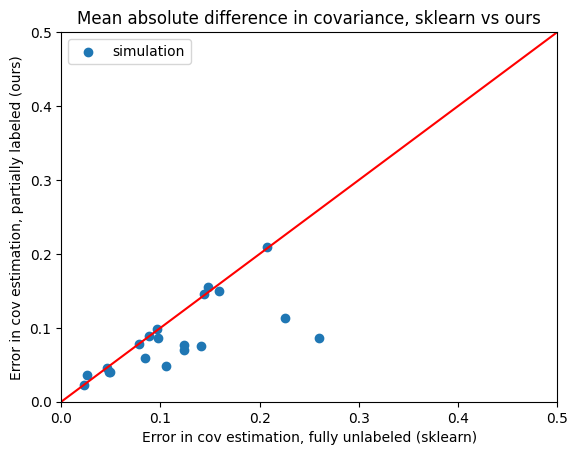

In [8]:
plt.scatter(covs_diffs_unlabeled, covs_diffs_labeled, label="simulation")
plt.xlabel("Error in cov estimation, fully unlabeled (sklearn)")
plt.ylabel("Error in cov estimation, partially labeled (ours)")
plt.title("Mean absolute difference in covariance, sklearn vs ours")
plt.plot([0, 0.5], [0, 0.5], color="red")
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)

plt.legend()

plt.show()